# Final model

Here the final model will be fine-tuned and trained. Once trained, it will be evaluated.

If possible: a mix of Gradient Boosted, LSTM and Random Forest

In [10]:
import polars as pl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load data
df_long = pl.read_parquet("../data/processed_data/df_long.parquet")
pdf = df_long.sort(["Drink", "Date"]).to_pandas()
pdf["Date"] = pd.to_datetime(pdf["Date"])

# Feature engineering (same as ML models)
pdf["year"] = pdf["Date"].dt.year
pdf["month"] = pdf["Date"].dt.month
pdf["dayofweek"] = pdf["Date"].dt.dayofweek
pdf["is_weekend"] = (pdf["dayofweek"] >= 5).astype(int)

pdf["lag1"] = pdf.groupby("Drink")["Views"].shift(1)
pdf["lag7"] = pdf.groupby("Drink")["Views"].shift(7)
pdf["lag14"] = pdf.groupby("Drink")["Views"].shift(14)

pdf["roll7_mean"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)
pdf["roll7_std"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=2).std())
)
pdf["roll7_std"] = pdf["roll7_std"].fillna(0.0)

pdf = pdf.dropna(subset=["lag1", "lag7", "lag14"])

# Train/Test split
cutoff = pd.Timestamp(2025, 1, 1)
train_pdf = pdf[pdf["Date"] < cutoff].copy()
test_pdf = pdf[pdf["Date"] >= cutoff].copy()

# One-hot encode
train_pdf = pd.get_dummies(train_pdf, columns=["Drink"], drop_first=False)
test_pdf = pd.get_dummies(test_pdf, columns=["Drink"], drop_first=False)
test_pdf = test_pdf.reindex(columns=train_pdf.columns, fill_value=0)

# Extract features
target = "Views"
feature_cols = [c for c in train_pdf.columns if c not in ["Views", "Date"]]

X_train = train_pdf[feature_cols].values
y_train = train_pdf[target].values
X_test = test_pdf[feature_cols].values
y_test = test_pdf[target].values

# Impute NaNs
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Train shape: (16310, 19), Test shape: (3350, 19)
y_train shape: (16310,), y_test shape: (3350,)


In [11]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"X_train scaled: {X_train_scaled.shape}")
print(f"y_train scaled: {y_train_scaled.shape}")

X_train scaled: (16310, 19)
y_train scaled: (16310,)


## Final Ensemble Forecast (Gradient Boosting + Random Forest + LSTM)
Train ensemble components and forecast January 2026; blend predictions for a final forecast.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Train tree models on original (imputed) features
rf_final = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
gb_final = GradientBoostingRegressor(random_state=42)
rf_final.fit(X_train, y_train)
gb_final.fit(X_train, y_train)

# Helper to build feature row for a given drink/date from history
all_drinks = df_long['Drink'].unique().to_list()

# Base history with original data
hist_df = pdf[["Date", "Drink", "Views"]].copy().sort_values(["Drink", "Date"])

feature_template = train_pdf[feature_cols].columns

look_back = 7  # re-use from LSTM training
lstm_buffer = list(X_train_scaled[-look_back:])  # start buffer with recent scaled features

future_dates = pd.date_range("2026-01-01", "2026-01-31", freq="D")

ensemble_forecasts = []

for current_date in future_dates:
    for drink in all_drinks:
        sub = hist_df[hist_df["Drink"] == drink].sort_values("Date")
        # Compute lags with fallbacks
        lag1 = sub["Views"].iloc[-1] if len(sub) >= 1 else 0.0
        lag7 = sub["Views"].iloc[-7] if len(sub) >= 7 else lag1
        lag14 = sub["Views"].iloc[-14] if len(sub) >= 14 else lag1
        roll7_mean = sub["Views"].tail(7).mean() if len(sub) >= 1 else 0.0
        roll7_std = sub["Views"].tail(7).std(ddof=0) if len(sub) >= 2 else 0.0

        row = {
            "year": current_date.year,
            "month": current_date.month,
            "dayofweek": current_date.dayofweek,
            "is_weekend": int(current_date.dayofweek >= 5),
            "lag1": lag1,
            "lag7": lag7,
            "lag14": lag14,
            "roll7_mean": roll7_mean,
            "roll7_std": roll7_std,
        }
        # One-hot drink columns
        for col in feature_template:
            if col.startswith("Drink_"):
                row[col] = 1 if col == f"Drink_{drink}" else 0

        # Build aligned vector (DataFrame for ordering, then convert to ndarray)
        x_vec = pd.DataFrame([row], columns=feature_template).fillna(0.0)
        x_np = x_vec.values

        # Tree predictions (use ndarray to avoid feature-name warnings)
        pred_rf = rf_final.predict(x_np)[0]
        pred_gb = gb_final.predict(x_np)[0]

        # LSTM prediction
        x_scaled = scaler_X.transform(x_np)
        lstm_buffer.append(x_scaled.flatten())
        seq = np.array(lstm_buffer[-look_back:]).reshape(1, look_back, X_train_scaled.shape[1])
        pred_lstm_scaled = model_lstm.predict(seq, verbose=0).flatten()[0]
        pred_lstm = scaler_y.inverse_transform([[pred_lstm_scaled]]).flatten()[0]

        # Blend
        final_pred = np.mean([pred_rf, pred_gb, pred_lstm])

        # Store forecast
        ensemble_forecasts.append({
            "Date": current_date,
            "Drink": drink,
            "Pred_Ensemble": final_pred,
            "Pred_RF": pred_rf,
            "Pred_GB": pred_gb,
            "Pred_LSTM": pred_lstm,
        })

        # Append prediction to history for recursive lags
        hist_df = pd.concat([
            hist_df,
            pd.DataFrame({"Date": [current_date], "Drink": [drink], "Views": [final_pred]})
        ], ignore_index=True)

# Create forecast DataFrame
forecast_df = pd.DataFrame(ensemble_forecasts)
print(forecast_df.head())

        Date            Drink  Pred_Ensemble    Pred_RF      Pred_GB  \
0 2026-01-01     "Chai latte"     690.510923     2.0975    11.860638   
1 2026-01-01  "Hot chocolate"     986.093274   573.3375   569.338052   
2 2026-01-01            "Tea"    1425.061631  1293.9325  1283.255628   
3 2026-01-01    "Iced coffee"     596.981387   136.9225   126.244248   
4 2026-01-01     "Bubble tea"    1286.232642  1136.9350  1117.896849   

     Pred_LSTM  
0  2057.574632  
1  1815.604270  
2  1697.996766  
3  1527.777414  
4  1603.866076  


## Ensemble Forecast Plots (January 2026)
Visualize ensemble vs individual components and per-drink breakdown.

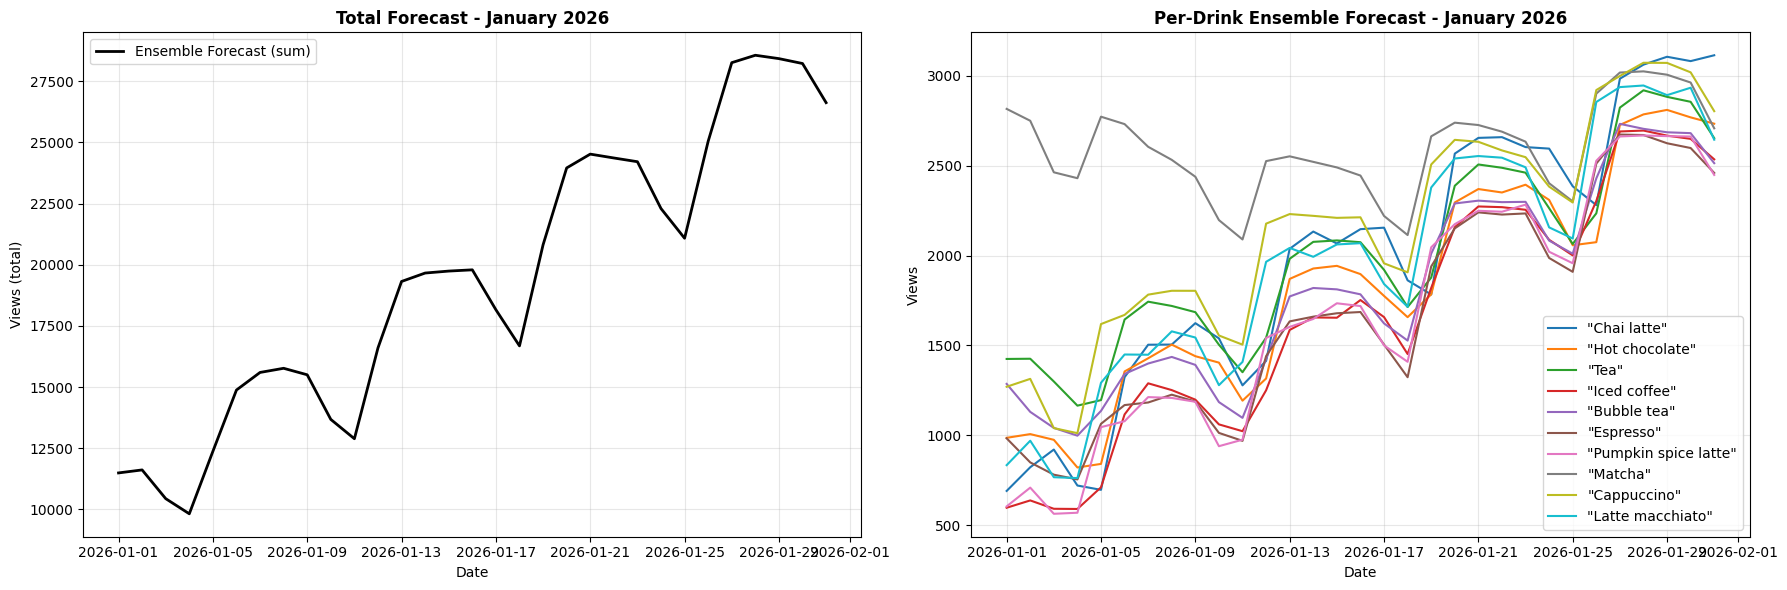

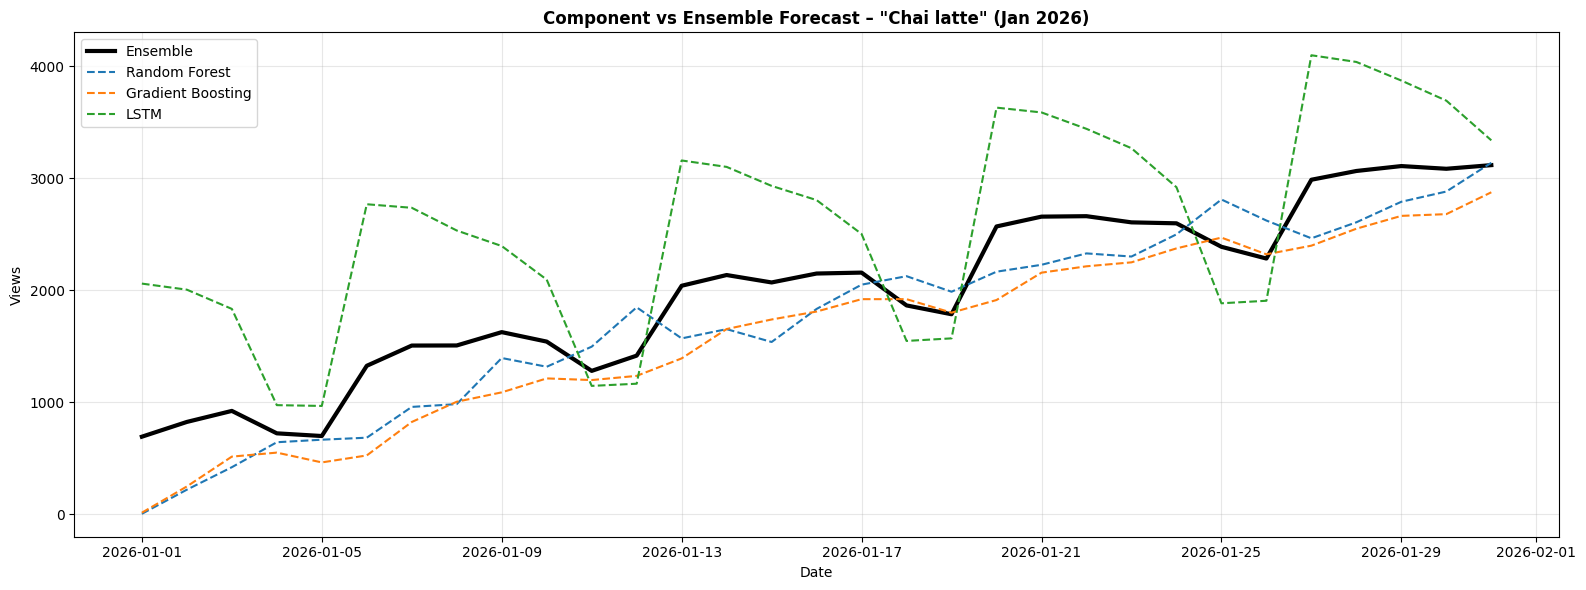

In [13]:
# Aggregate ensemble forecast
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Overall (all drinks combined)
agg = forecast_df.groupby("Date")["Pred_Ensemble"].sum()
axes[0].plot(agg.index, agg.values, label="Ensemble Forecast (sum)", color="black", linewidth=2)
axes[0].set_title("Total Forecast - January 2026", fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Views (total)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Per-drink breakdown
for drink in all_drinks:
    df_d = forecast_df[forecast_df["Drink"] == drink]
    axes[1].plot(df_d["Date"], df_d["Pred_Ensemble"], label=drink)
axes[1].set_title("Per-Drink Ensemble Forecast - January 2026", fontweight="bold")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Views")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Component comparison for first drink
first_drink = all_drinks[0]
df_first = forecast_df[forecast_df["Drink"] == first_drink]
plt.figure(figsize=(16,6))
plt.plot(df_first["Date"], df_first["Pred_Ensemble"], label="Ensemble", linewidth=3, color="black")
plt.plot(df_first["Date"], df_first["Pred_RF"], label="Random Forest", linestyle="--")
plt.plot(df_first["Date"], df_first["Pred_GB"], label="Gradient Boosting", linestyle="--")
plt.plot(df_first["Date"], df_first["Pred_LSTM"], label="LSTM", linestyle="--")
plt.title(f"Component vs Ensemble Forecast – {first_drink} (Jan 2026)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
